In [1]:
import pandas as pd
import numpy as np
import os
import json
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage import feature, color, io
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

First training annotation: {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [119, 25, 205, 606], 'area': 124230, 'segmentation': [], 'iscrowd': 0}


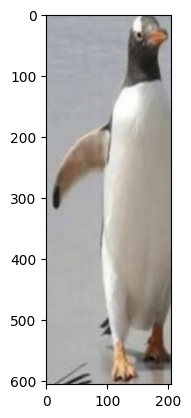

In [2]:
# Define paths
train_dir = 'HSV_Train_Imgs'
valid_dir = 'HSV_Valid_Images'
train_ann = 'train_annotations'
valid_ann = 'valid_annotations'

# Load annotations
with open(train_ann, 'r') as f:
    train_annotations = json.load(f)

with open(valid_ann, 'r') as f:
    valid_annotations = json.load(f)

# Display the first annotation
print(f"First training annotation: {train_annotations[0]}")

# Define the path to the first imag
first_image_path = os.path.join(train_dir, f"{str(train_annotations[0]['image_id']).zfill(1)}.jpg")

# Open the image
with Image.open(first_image_path) as img:
    plt.imshow(img)
    plt.show()

In [3]:
# HOG features from an image
def extract_features(image_path):
    with Image.open(image_path) as img:
        img_resized = img.resize((128, 128))  # resize image
        img_gray = color.rgb2gray(np.array(img_resized))  # convert to grayscale
        features, hog_image = feature.hog(img_gray, orientations=16, pixels_per_cell=(16, 16), visualize=True)
    return features

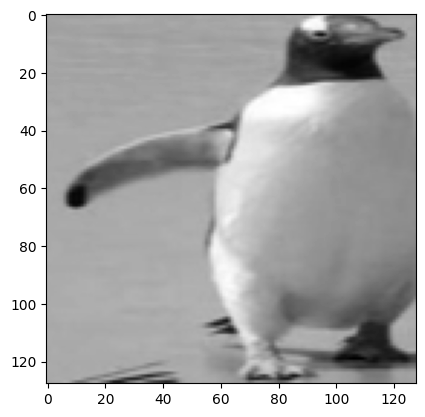

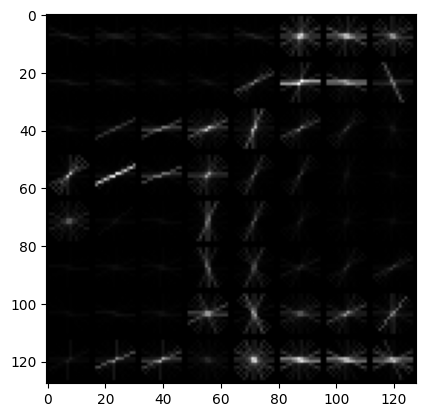

In [4]:
# Open the image resize and convert
with Image.open(first_image_path) as img:
    img_resized = img.resize((128, 128))
    gray_img = color.rgb2gray(np.array(img_resized))
    plt.imshow(gray_img, cmap='gray')
    plt.show()

# Compute the HOG features of the grayscale image
hog_features, hog_image = feature.hog(gray_img, orientations=16, pixels_per_cell=(16, 16), visualize=True)

# Display the HOG image
plt.imshow(hog_image, cmap='gray')
plt.show()

In [5]:
# Prepare the train data
X_train = []
y_train = []

for annotation in train_annotations:
    image_path = os.path.join(train_dir, f"{str(annotation['image_id']).zfill(1)}.jpg")
    features = extract_features(image_path)
    X_train.append(features)
    y_train.append(annotation['category_id'])

# Convert lists to arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Split the dataset for training and validation
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the PCA
pca = PCA()

# Define the SVM
svm = svm.SVC()

# Define a pipeline that applies PCA, then trains an SVM
pipeline = Pipeline(steps=[('pca', pca), ('svm', svm)])

In [6]:
# Define the parameter grid
param_grid = {
    'pca__n_components': [0.95, 0.9, 0.85, 0.8],
    'svm__C': [0.1, 1, 10, 20, 30, 50, 100, 200, 500, 1000], 
    'svm__gamma': [1, 0.5, 0.2, 0.01, 0.05, 0.01, 0.005, 0.001, 0.0001],
    'svm__kernel': ['rbf']} 

# Create a GridSearchCV object
grid = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the model to the data
grid.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid.best_params_}")

# Print the best score
print(f"Best score: {grid.best_score_}")

# Make predictions on the validation set
grid_predictions = grid.predict(X_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, grid_predictions))

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, grid_predictions, target_names=['Penguin', 'Turtle']))

Best parameters: {'pca__n_components': 0.8, 'svm__C': 50, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best score: 0.9275
Confusion Matrix:
[[46  7]
 [ 2 45]]

Classification Report:
              precision    recall  f1-score   support

     Penguin       0.96      0.87      0.91        53
      Turtle       0.87      0.96      0.91        47

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



In [7]:
# Prepare the validation data
X_valid = []
y_valid = []

for annotation in valid_annotations:
    image_path = os.path.join(valid_dir, f"{str(annotation['image_id']).zfill(1)}.jpg")
    features = extract_features(image_path)
    X_valid.append(features)
    y_valid.append(annotation['category_id'])

# Convert lists to arrays
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

# Make predictions on the validation set
y_valid_pred = grid.predict(X_valid)

# Print the confusion matrix
print("Confusion Matrix for Validation Set:")
print(confusion_matrix(y_valid, y_valid_pred))

# Print the classification report
print("\nClassification Report for Validation Set:")
print(classification_report(y_valid, y_valid_pred, target_names=['Penguin', 'Turtle']))

# Print the accuracy on the validation set
print(f"Validation accuracy with best parameters: {grid.score(X_valid, y_valid)}")

Confusion Matrix for Validation Set:
[[31  5]
 [ 3 33]]

Classification Report for Validation Set:
              precision    recall  f1-score   support

     Penguin       0.91      0.86      0.89        36
      Turtle       0.87      0.92      0.89        36

    accuracy                           0.89        72
   macro avg       0.89      0.89      0.89        72
weighted avg       0.89      0.89      0.89        72

Validation accuracy with best parameters: 0.8888888888888888
